<a href="https://colab.research.google.com/github/sailkargutkar/Python-Projects/blob/HELBNTODR100394/HELBNTODR100394.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Install all necessary packages

In [2]:
import numpy as np
import pandas as pd
import re
import spacy
import nltk
import matplotlib.pyplot as plt

from keras.layers.convolutional import Conv1D
from keras.layers import MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Embedding,SpatialDropout1D
from keras.layers import LSTM
from keras.layers import Dense, Activation
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score
from keras import layers
from keras.layers import Dropout 
from keras.models import Sequential
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# Import Decision tree classifier
from sklearn.tree import DecisionTreeClassifier

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

Loading dataset

In [36]:
df = pd.read_csv('/agr_en_train.csv', names=['id','Speech','Label'], sep=',')
print(df.iloc[0])

id                              facebook_corpus_msr_1723796
Speech    Well said sonu..you have courage to stand agai...
Label                                                   OAG
Name: 0, dtype: object


Preprocessing text

In [35]:
df.info()
df.Label.value_counts()
df=df.applymap(str)
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Speech'].values)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11999 entries, 0 to 11998
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   unique_id  11999 non-null  object
 1   Speech     11999 non-null  object
 2   Label      11999 non-null  object
dtypes: object(3)
memory usage: 281.4+ KB


Search for unique words and tokenize those words

In [6]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X = tokenizer.texts_to_sequences(df['Speech'].values)

Found 24713 unique tokens.


In [8]:
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (11999, 250)


In [9]:
Y = pd.get_dummies(df['Label']).values
print('Shape of label tensor:', Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Shape of label tensor: (11999, 3)
(10799, 250) (10799, 3)
(1200, 250) (1200, 3)


Fetching glove module and embeds eith texts

In [12]:
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [13]:
vocabulary_size=400000

Creating embedding matrix

In [14]:
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

hyperparameter-tuning

In [ ]:
# Create a Decision tree classifier model
clf = DecisionTreeClassifier()

# Hyperparameter Optimization
parameters = {'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10, 50], 
              'min_samples_split': [2, 3, 50, 100],
              'min_samples_leaf': [1, 5, 8, 10]
             }

# Run the grid search
grid_obj = GridSearchCV(clf, parameters)
grid_obj = grid_obj.fit(X_train, Y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Train the model using the training sets 
clf.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=50, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [26]:
# cnn with glove
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 100, input_length=250, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(3, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data
modhist = model_glove.fit(X_train, Y_train, validation_split=0.4, epochs = 3)
accr = model_glove.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Train on 6479 samples, validate on 4320 samples
Epoch 1/3
6479/6479 [==============================] - 23s 4ms/step - loss: 0.5948 - accuracy: 0.6905 - val_loss: 0.5770 - val_accuracy: 0.6982
Epoch 2/3
6479/6479 [==============================] - 22s 3ms/step - loss: 0.5627 - accuracy: 0.7066 - val_loss: 0.5617 - val_accuracy: 0.7086
Epoch 3/3
1200/1200 [==============================] - 1s 715us/step
Test set
  Loss: 0.551
  Accuracy: 0.712


In [29]:
predicted_value = model_glove.predict(X_test)
predicted_value = np.argmax(predicted_value, axis=1)
predicted_value_x = np.argmax(Y_test, axis=1)
print(confusion_matrix(predicted_value_x,predicted_value))
f1_score(predicted_value_x,predicted_value,average="micro")

[[252 179  13]
 [144 359  10]
 [162  63  18]]


0.5241666666666667

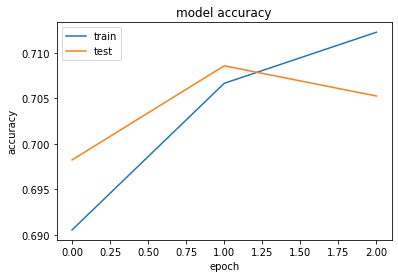

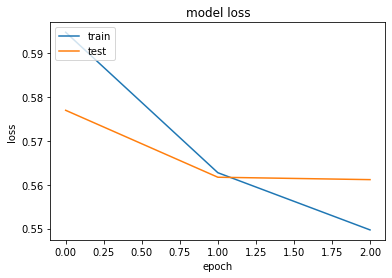

In [30]:
plt.plot(modhist.history['accuracy'])
plt.plot(modhist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(modhist.history['loss'])
plt.plot(modhist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()